# California Housing Dataset (5 features)

The following test compares three regression models on the California Housing dataset,and the following models
*   custom ElasticNet model *Project 1 class*
*   sklearn ElasticNet model
*   sklearn Linear Regression model

A Q-Q plot is used to check whether the residuals (differences between predicted and actual values) follow a normal distribution.

Custom ElasticNet - R²: 0.5057, MSE: 0.6581
Linear Regression - R²: 0.5144, MSE: 0.6466
Sklearn ElasticNet - R²: 0.5057, MSE: 0.6582


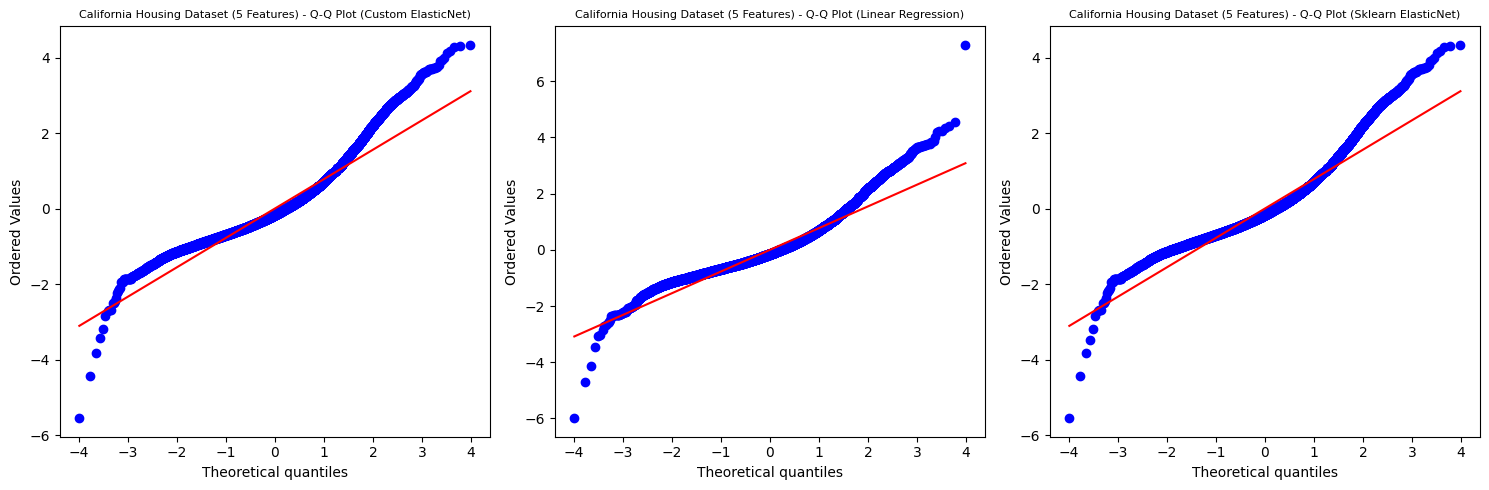

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import ElasticNet as SklearnElasticNet

# Load California Housing dataset
california_data = fetch_california_housing()
X = california_data.data
y = california_data.target

# Select 5 features (you can choose different ones if desired)
X = X[:, [0, 1, 2, 4, 5]]  # Selecting 5 features: MedInc, HouseAge, AveRooms, AveOccup, Latitude

# Standardize features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
non_zero_std = X_std != 0  # Detect non-zero variance features
X_std[~non_zero_std] = 1  # Prevent division by zero
X_scaled = (X - X_mean) / X_std


class ElasticNetModel:
    def __init__(self, alpha=1, l1_ratio=0.5, max_iter=1000, tol=1e-5, learning_rate=0.1):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
        # Standardize the features
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0)
        non_zero_std = X_std != 0  # Detect non-zero variance features
        X_std[~non_zero_std] = 1  # Prevent division by zero

        X_scaled = (X - X_mean) / X_std

        # Center the target
        y_mean = y.mean()
        y_centered = y - y_mean

        n_samples, n_features = X_scaled.shape
        coef_ = np.zeros(n_features)
        intercept_ = y_mean

        # Gradient descent loop
        for iteration in range(self.max_iter):
            y_pred = X_scaled @ coef_ + intercept_

            # Compute the residuals
            residuals = y_pred - y_centered

            # Compute the gradients (grad_coef should be of shape (n_features,))
            grad_coef = (X_scaled.T @ residuals) / n_samples

            # Add regularization terms
            regularization_term = self.alpha * (self.l1_ratio * np.sign(coef_) + (1 - self.l1_ratio) * coef_)
            grad_coef += regularization_term

            grad_intercept = np.sum(residuals) / n_samples

            # Update the coefficients and intercept
            coef_ -= self.learning_rate * grad_coef
            intercept_ -= self.learning_rate * grad_intercept

            # Check convergence
            coef_change = np.linalg.norm(grad_coef, ord=2)
            if coef_change < self.tol:
                break

        # Unscale the coefficients to match the original feature scale
        self.coef_ = coef_ / X_std
        self.intercept_ = y_mean - X_mean @ self.coef_

        return ElasticNetModelResults(self.coef_, self.intercept_)


class ElasticNetModelResults:
    def __init__(self, coef_, intercept_):
        self.coef_ = coef_
        self.intercept_ = intercept_

    def predict(self, X):
        """Predicts the target values using the fitted model parameters."""
        return X @ self.coef_ + self.intercept_


class MyMSE:
    @staticmethod
    def calculate(y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)


class MyRSquared:
    @staticmethod
    def calculate(y_true, y_pred):
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        return 1 - (ss_res / ss_tot)

# Function to plot Q-Q plots
def plot_qq(y_true, y_pred_custom, y_pred_linear, test_name):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    stats.probplot(y_true - y_pred_custom, dist="norm", plot=plt)
    plt.title(f'{test_name} - Q-Q Plot (Custom ElasticNet)')

    plt.subplot(1, 2, 2)
    stats.probplot(y_true - y_pred_linear, dist="norm", plot=plt)
    plt.title(f'{test_name} - Q-Q Plot (Linear Regression)')

    plt.tight_layout()
    plt.show()

# Instantiate classes for MSE and R²
mse_calculator = MyMSE()
rsquared_calculator = MyRSquared()

# Initialize and fit ElasticNetModel
model = ElasticNetModel(alpha=0.05, l1_ratio=0.9, max_iter=500, tol=1e-5, learning_rate=0.05)
model_results = model.fit(X_scaled, y)
y_pred_custom = model_results.predict(X_scaled)

# Initialize and fit LinearRegression from sklearn
linear_model = LinearRegression()
linear_model.fit(X_scaled, y)
y_pred_linear = linear_model.predict(X_scaled)

# Initialize and fit ElasticNet from sklearn
sklearn_elasticnet = SklearnElasticNet(alpha=0.05, l1_ratio=0.9, max_iter=500, tol=1e-5)
sklearn_elasticnet.fit(X_scaled, y)
y_pred_sklearn_elasticnet = sklearn_elasticnet.predict(X_scaled)


# Evaluate custom ElasticNet and LinearRegression models using custom MSE and R²
r_squared_custom = rsquared_calculator.calculate(y, y_pred_custom)
mse_custom = mse_calculator.calculate(y, y_pred_custom)
r_squared_linear = r2_score(y, y_pred_linear)
mse_linear = mean_squared_error(y, y_pred_linear)
r_squared_sklearn_elasticnet = r2_score(y, y_pred_sklearn_elasticnet)
mse_sklearn_elasticnet = mean_squared_error(y, y_pred_sklearn_elasticnet)


# Print results
print(f"Custom ElasticNet - R²: {r_squared_custom:.4f}, MSE: {mse_custom:.4f}")
print(f"Linear Regression - R²: {r_squared_linear:.4f}, MSE: {mse_linear:.4f}")
print(f"Sklearn ElasticNet - R²: {r_squared_sklearn_elasticnet:.4f}, MSE: {mse_sklearn_elasticnet:.4f}")

def plot_qq(y_true, y_pred_custom, y_pred_linear, y_pred_sklearn_elasticnet, test_name, font_size=12):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    stats.probplot(y_true - y_pred_custom, dist="norm", plot=plt)
    plt.title(f'{test_name} - Q-Q Plot (Custom ElasticNet)', fontsize=font_size)

    plt.subplot(1, 3, 2)
    stats.probplot(y_true - y_pred_linear, dist="norm", plot=plt)
    plt.title(f'{test_name} - Q-Q Plot (Linear Regression)', fontsize=font_size)

    plt.subplot(1, 3, 3)
    stats.probplot(y_true - y_pred_sklearn_elasticnet, dist="norm", plot=plt)
    plt.title(f'{test_name} - Q-Q Plot (Sklearn ElasticNet)', fontsize=font_size)

    plt.tight_layout()
    plt.show()

# Plot Q-Q plot for California Housing dataset with custom font size
plot_qq(y, y_pred_custom, y_pred_linear, y_pred_sklearn_elasticnet, "California Housing Dataset (5 Features)", font_size=8)




All models show some deviations from normality, especially in the tails, meaning the residuals are not perfectly normal.

The Linear Regression model performed slightly better, with an R² of 0.5144 and MSE of 0.6466, compared to the custom and sklearn ElasticNet models, which had nearly identical results (R² of 0.5057 and MSE around 0.658).

Despite these differences, the models are fairly close, with Linear Regression having a slight edge in terms of fit.

Conclusion. The similar results between the custom ElasticNet and Linear Regression models suggest that the custom ElasticNet isn’t effectively applying penalization, essentially replicating Linear Regression. This implies the dataset may not be well-suited for ElasticNet, as the regularization isn’t improving the model’s performance.